# Example Usage for Cleaning Stimulation Pulses with Zappy

# Main Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

import zappy

# Load Data

In [2]:
def get_stim_data():
    from tqdm import tqdm
    import wget
    import zipfile
    import os
    
    url = "https://www.dropbox.com/sh/yqf36798y1yz9e8/AACcqZdu09Chlvkr1NOFFsiQa?dl=1"
    out = './stim_24k.zip'
    fname = './data/EC206_B18_stim_example.npz'
    if not os.path.exists(fname):
        if not os.path.exists(out):
            print('Downloading sample data...')
            wget.download(url, out=out, bar=wget.bar_thermometer)
        
        print('Extracting sample data...')
        with zipfile.ZipFile(out, 'r') as zipObj:
            zipObj.extractall('./data')
            
        os.remove(out)
            
    npz = zappy.io.sigdict.load_data_dict(fname)
    print('Loaded sample data.')    
    
    return npz

# Download / load-in sample data
npz = get_stim_data()

# Get data sizes
n_time = npz['stim'].shape[0]
n_stim = npz['stim'].shape[1]
tstamp = np.arange(0, n_time / npz['Fs'], 1/npz['Fs'])

Loaded sample data.


# Visualize Stimulation Pulses 

## Full Stim Sequence

In [ ]:
plt.figure(figsize=(24,12))
for i in range(n_stim):
    ax = plt.subplot(n_stim, 1, i+1)
    ax.plot(tstamp, npz['stim'][:,i])
    ax.set_ylim([-2500, 2500])
    
    if i < (n_stim-1):
        ax.set_xticks([])
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Stim Current (uA)')

## Zoomed-In Plot

In [ ]:
plt.figure(figsize=(24,12))
for i in range(n_stim):
    ax = plt.subplot(n_stim, 1, i+1)
    ax.plot(tstamp, npz['stim'][:,i])
    ax.set_ylim([-2500, 2500])
    
    if i < (n_stim-1):
        ax.set_xticks([])
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Stim Current (uA)')
    
    ax.set_xlim([45, 52])

# Run Zappy

Locating stimulation pulses from input sequence...
Determining non-pulse periods to use as control...
Clipping and aggregating iEEG around stim pulses...
Clipping and aggregating iEEG around non-stim pulses...
Training ICA models on stim pulses and non-stim pulses...
Calculating summary statistic on distribution of ICs...
Reconstructing iEEG of stim pulses after removing corrupt components...
Independent Components of Stim Pulses...


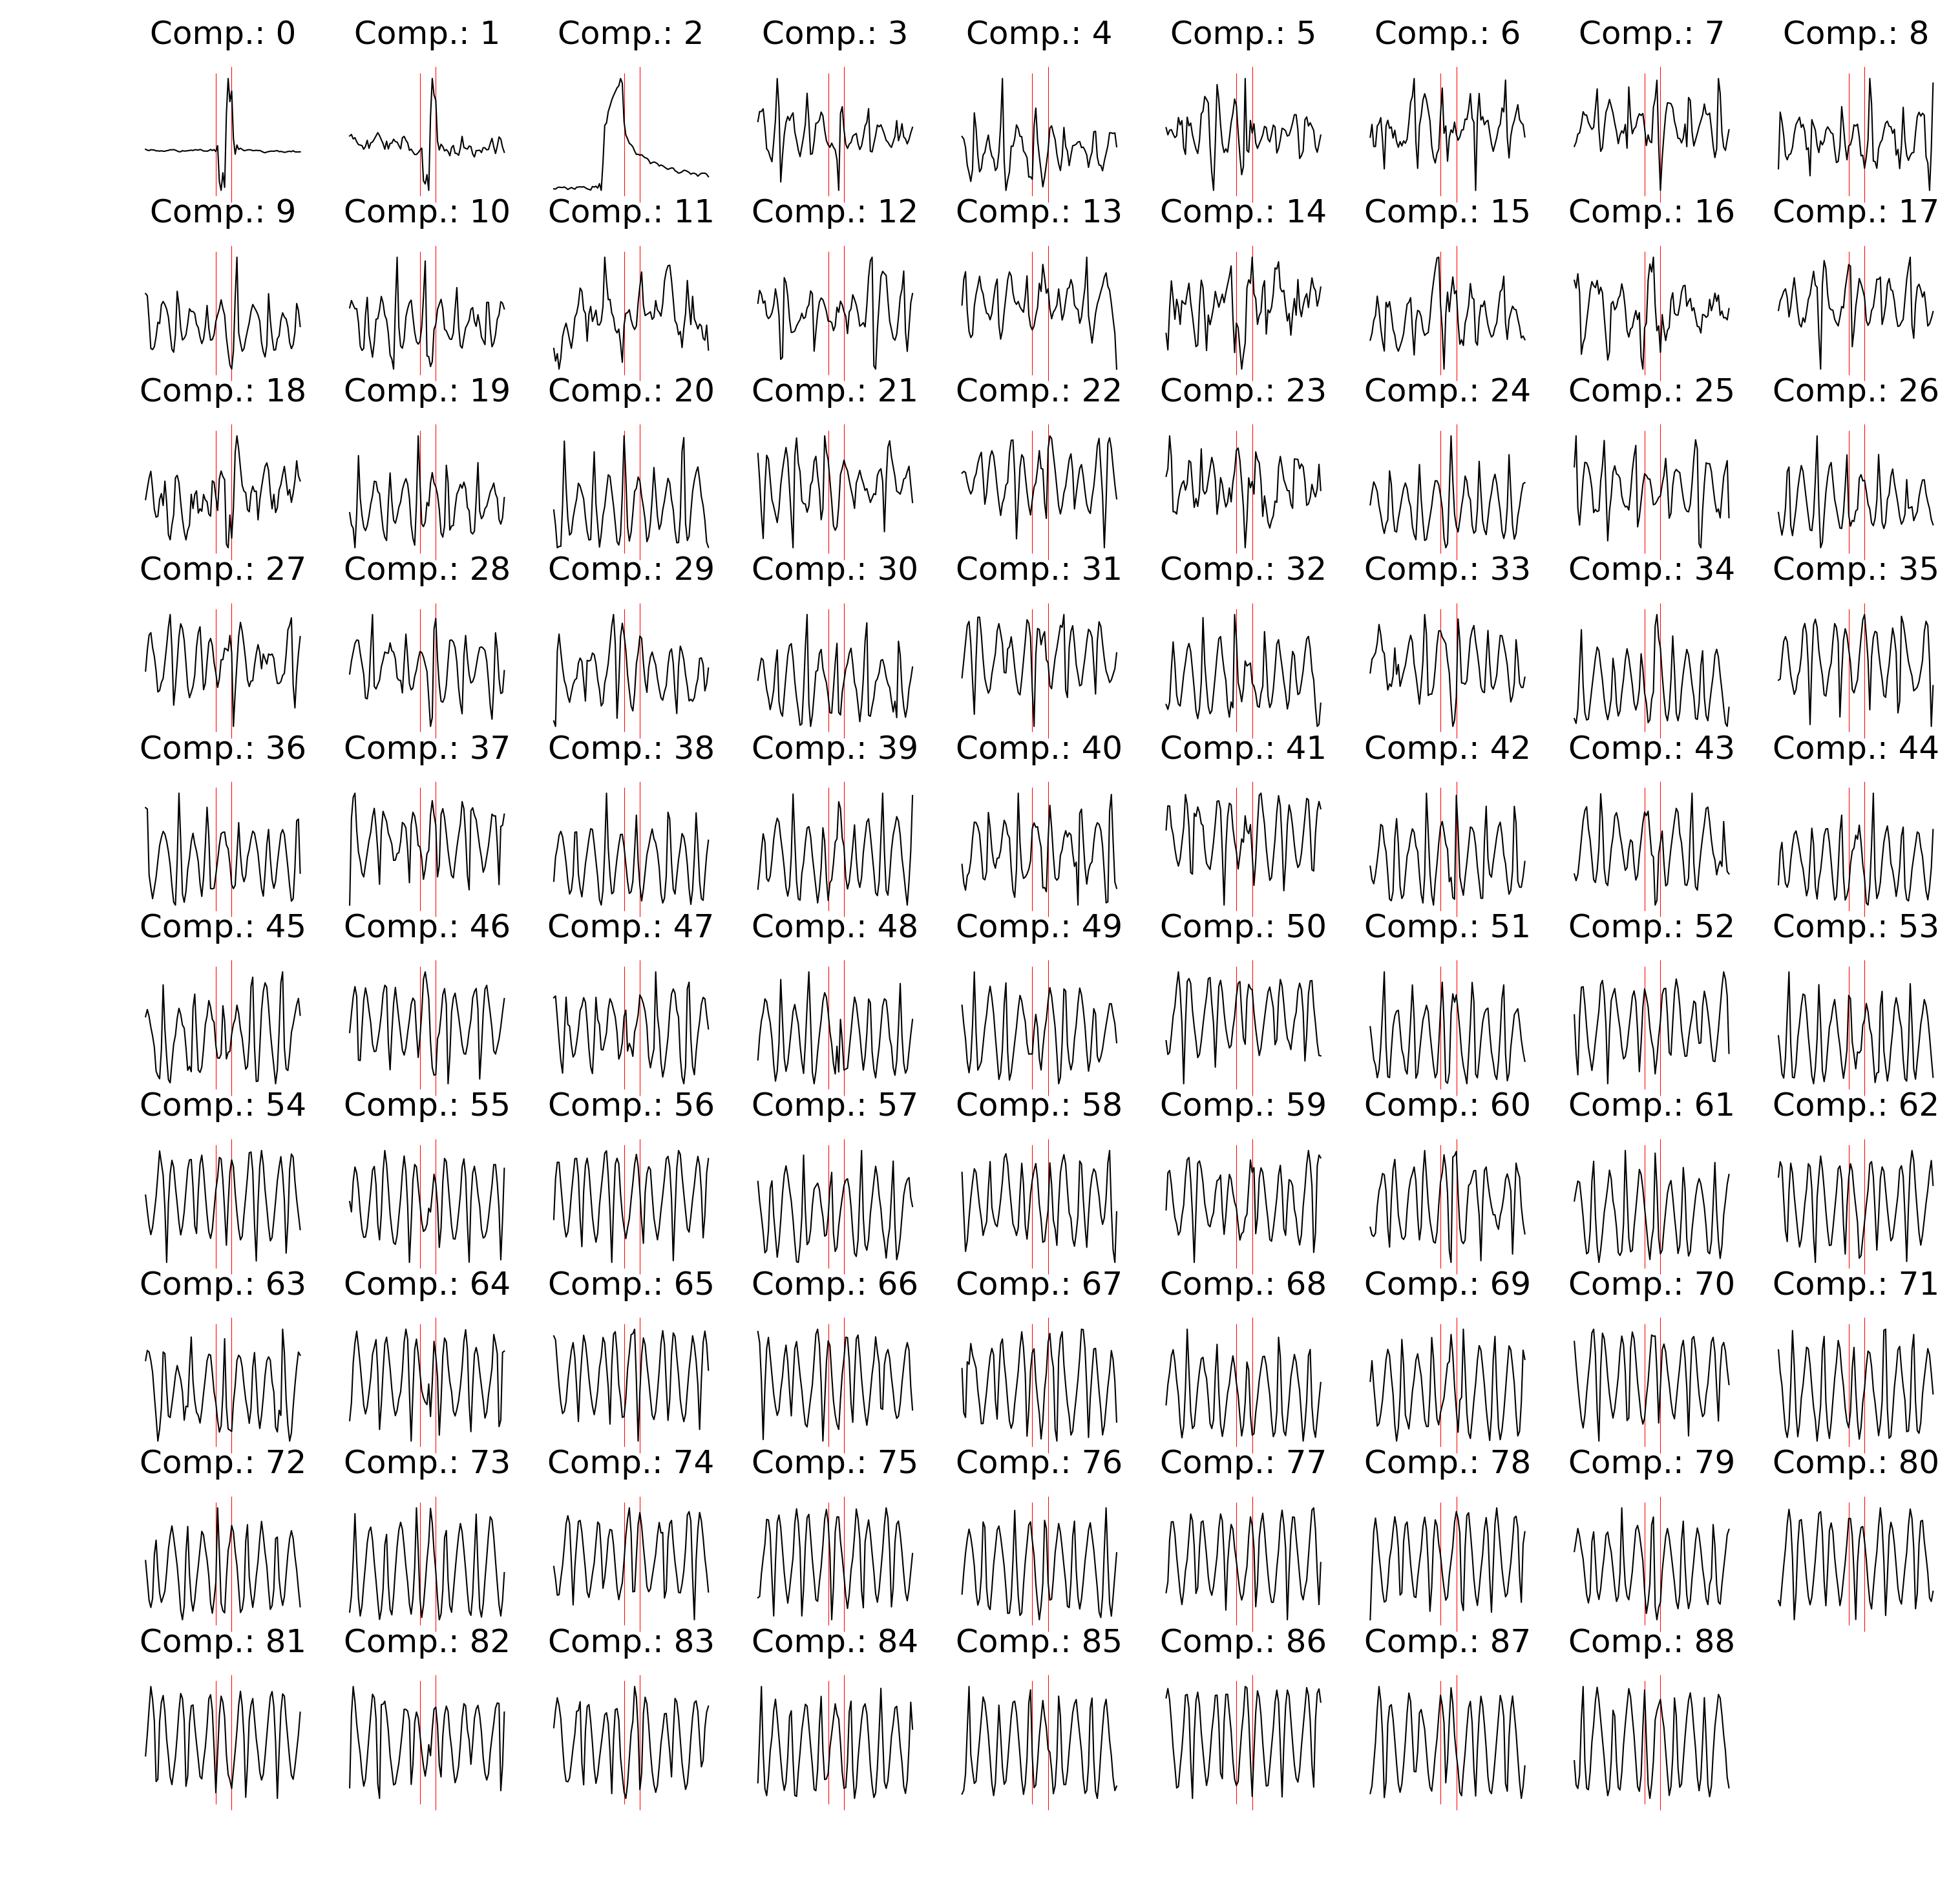

Independent Components of Non-Stim Pulses...


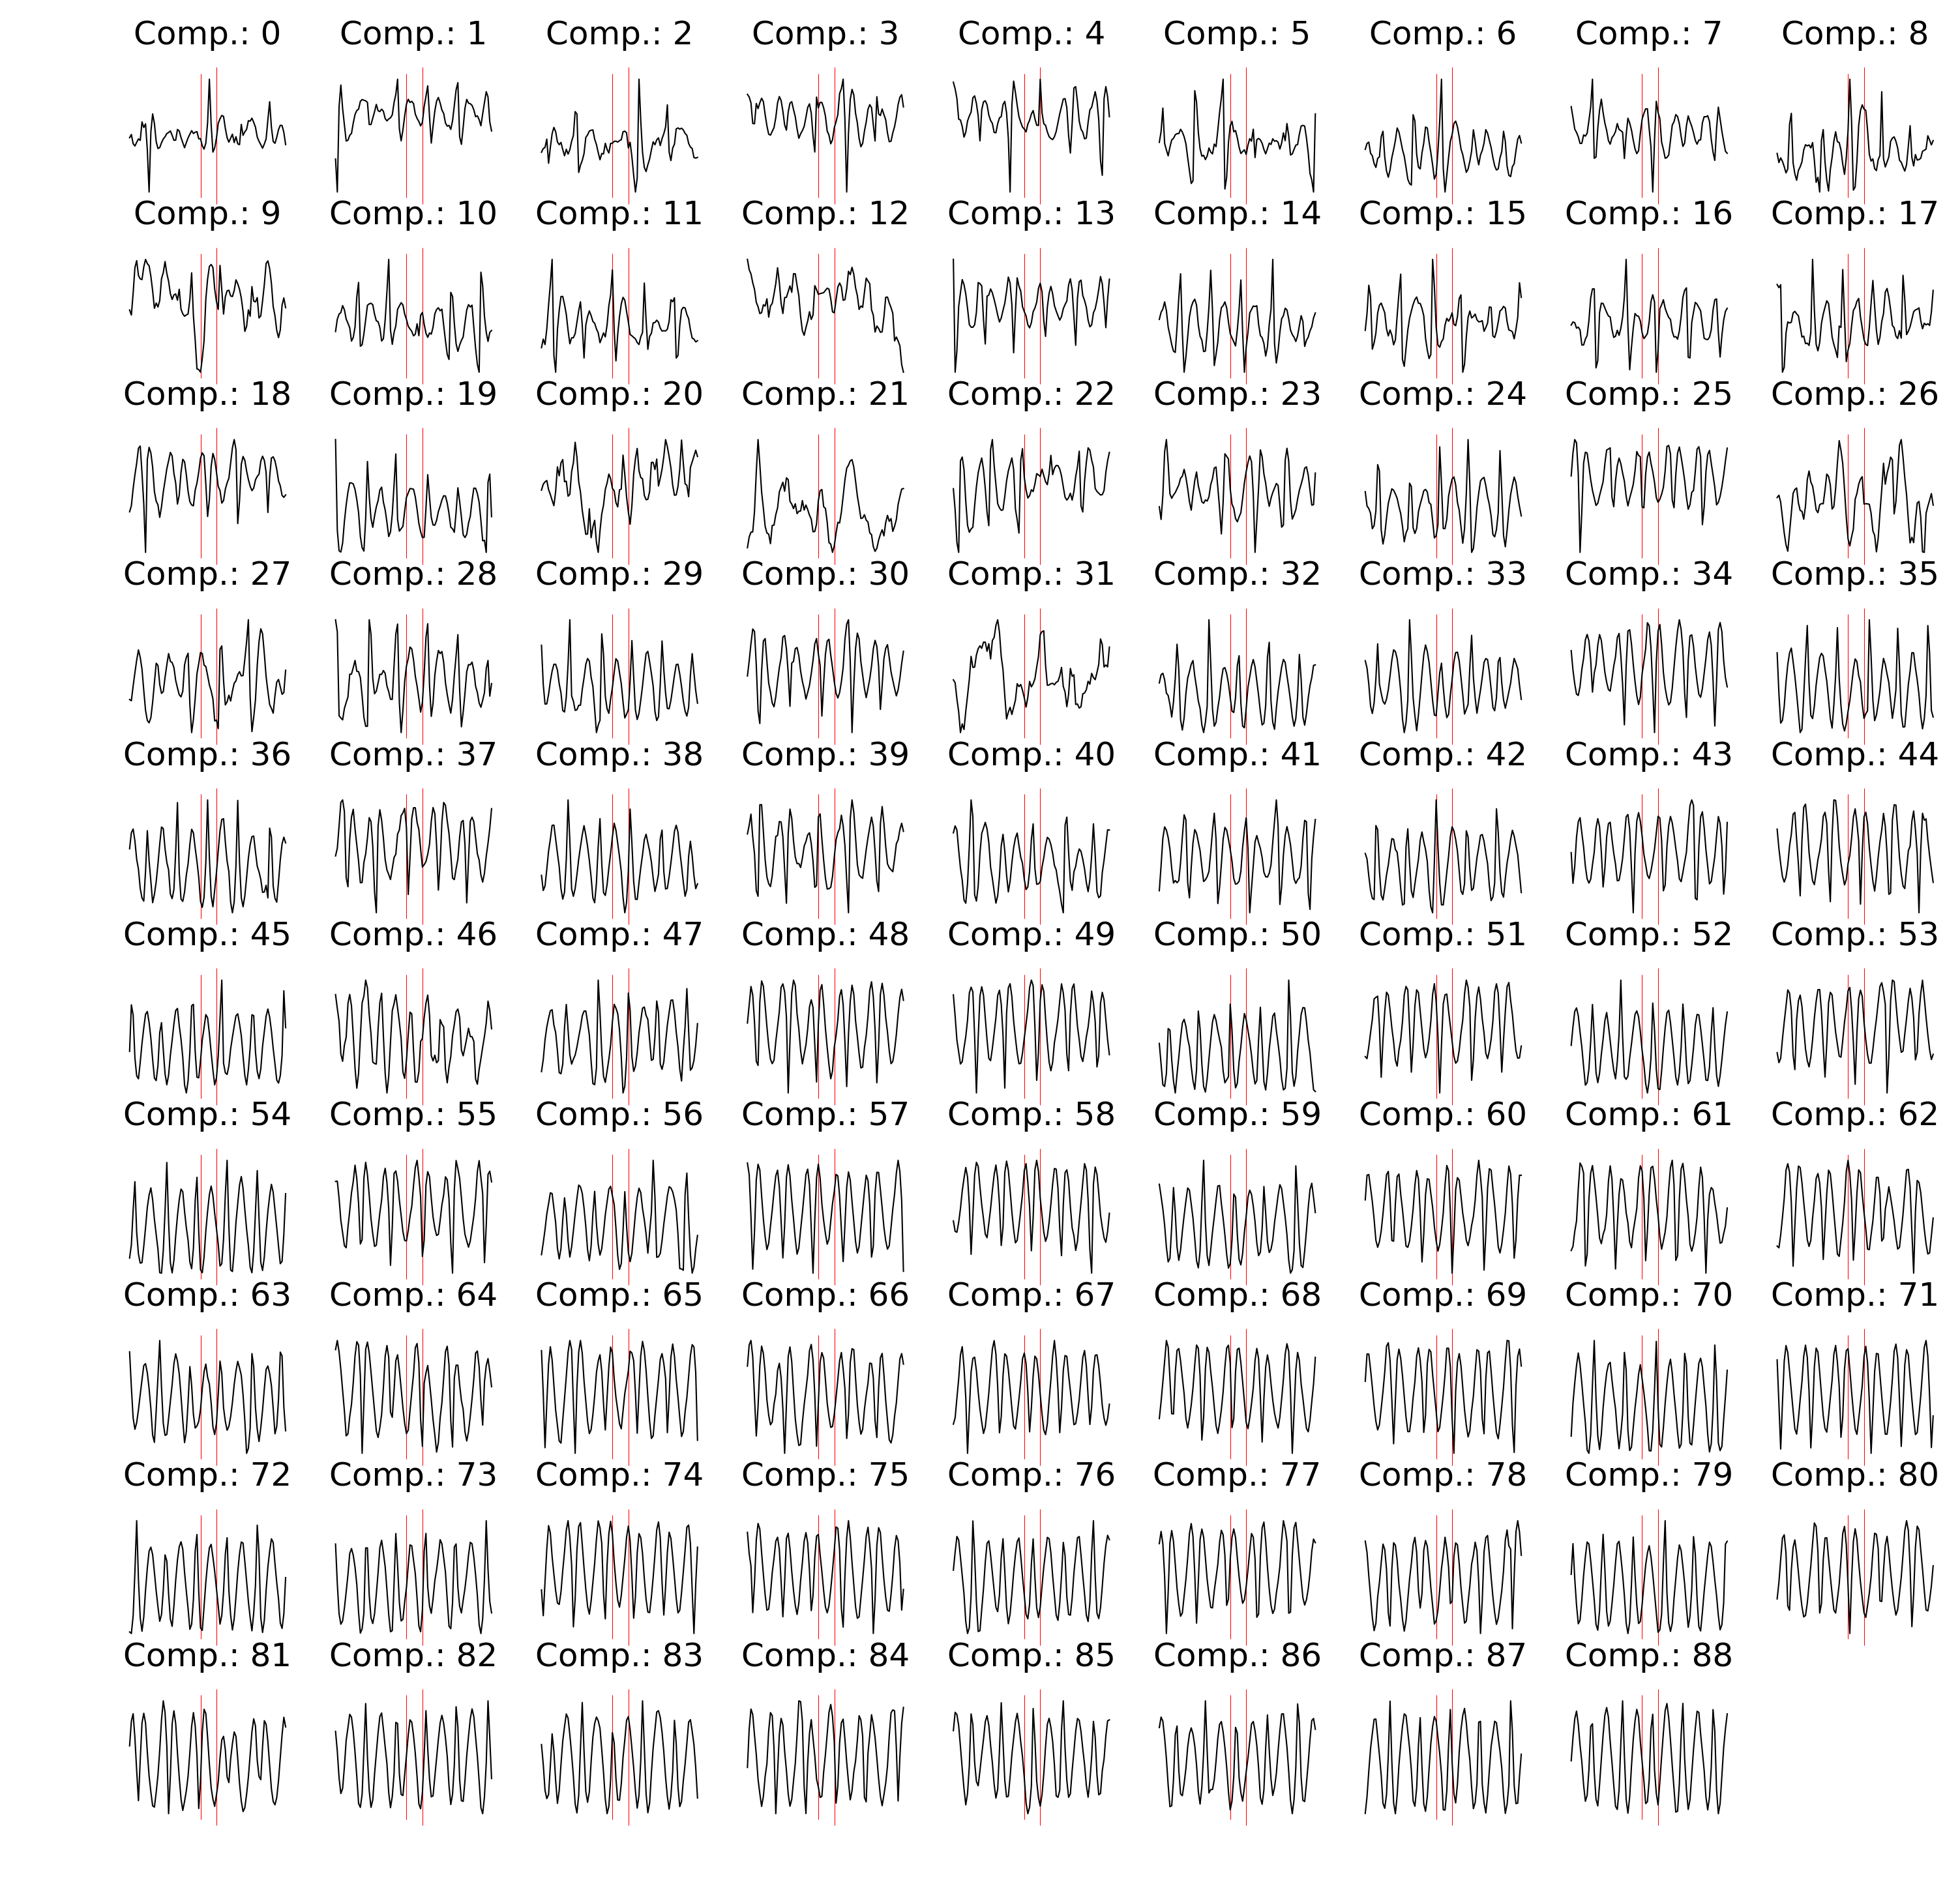

Distribution of summary stat values for IC removal...


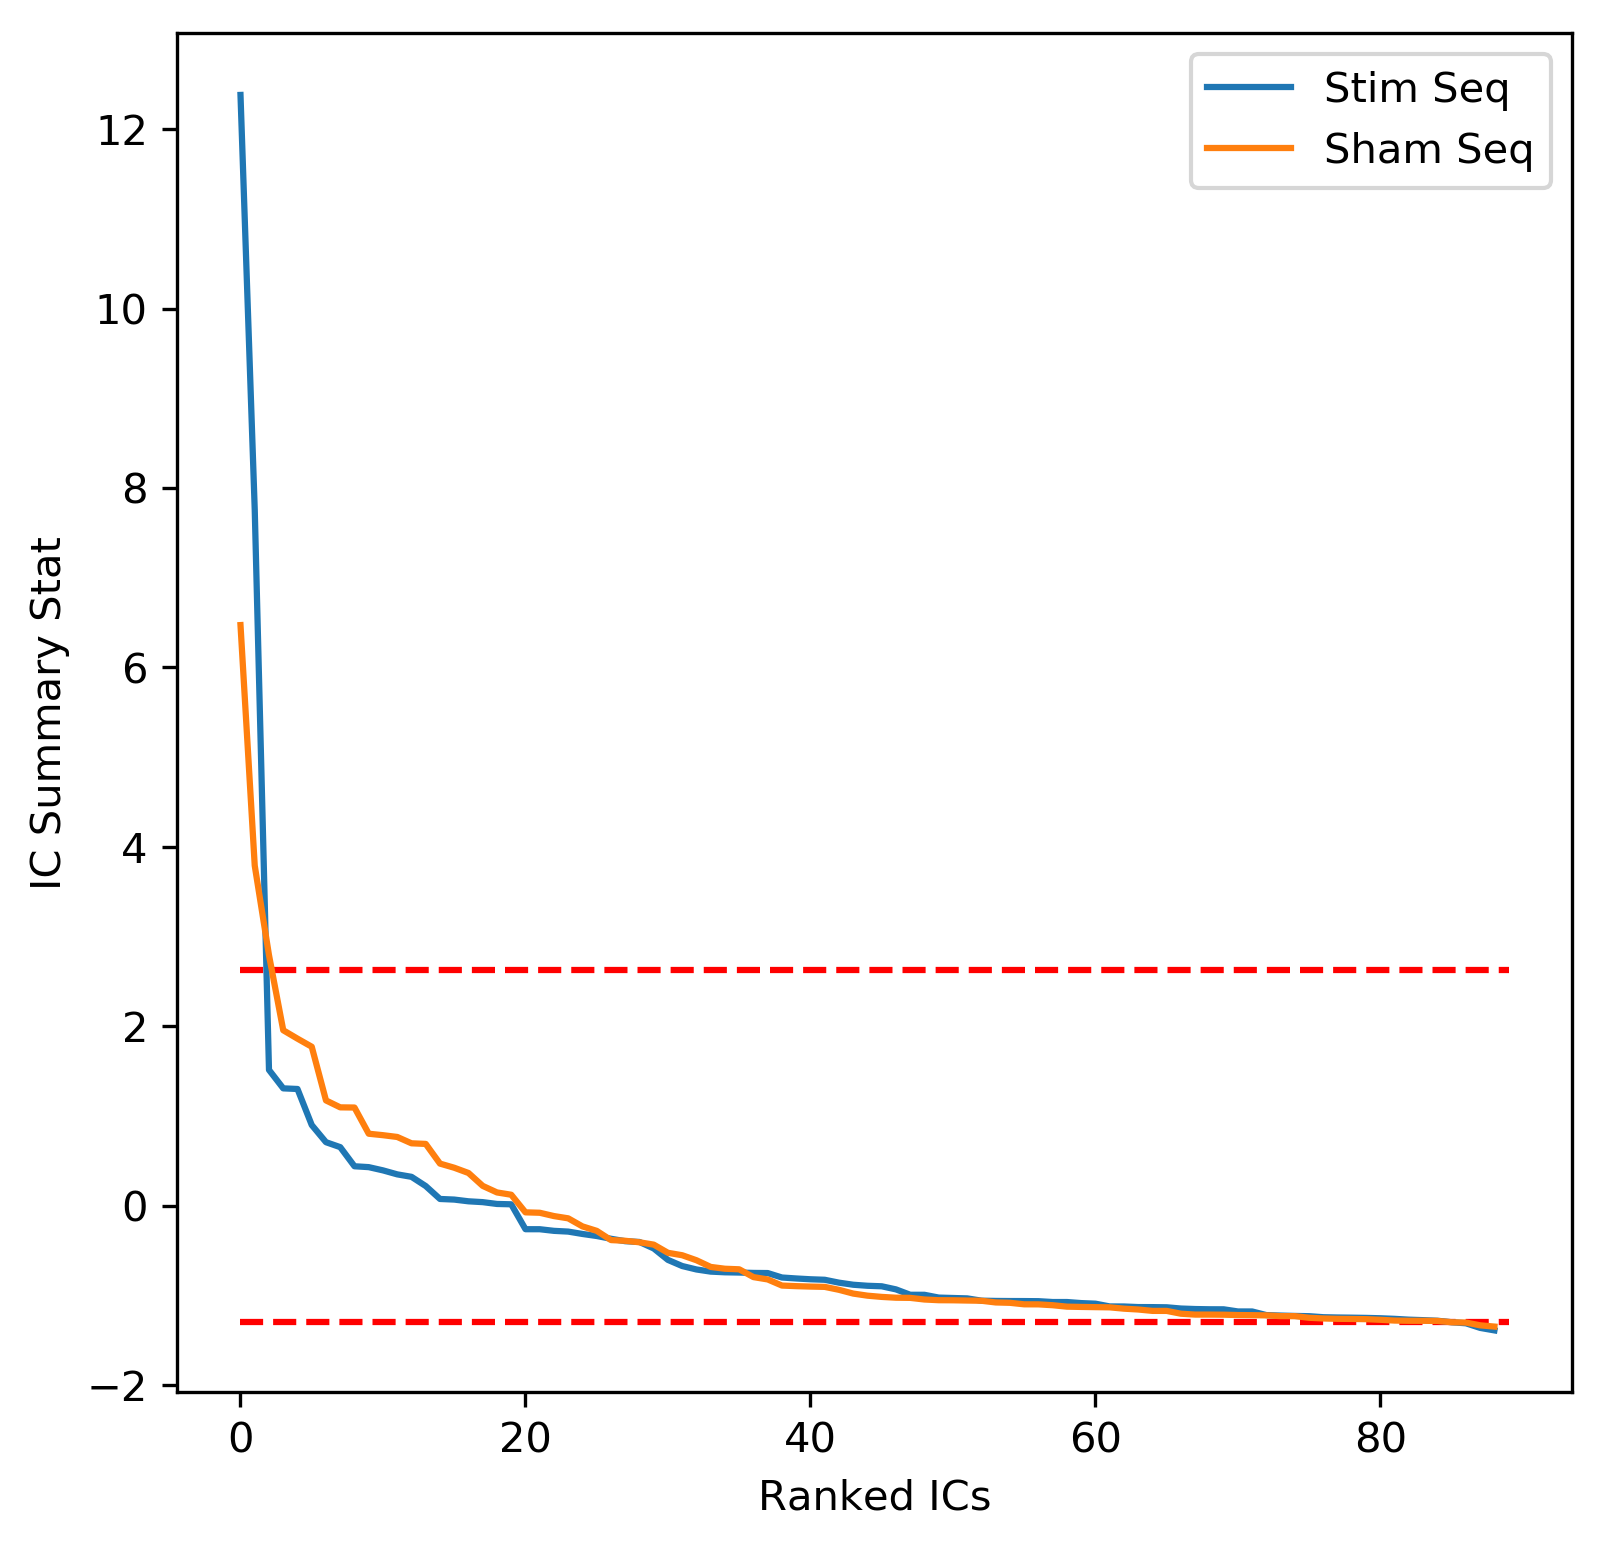

Example iEEG of stim pulses before/after IC removal...


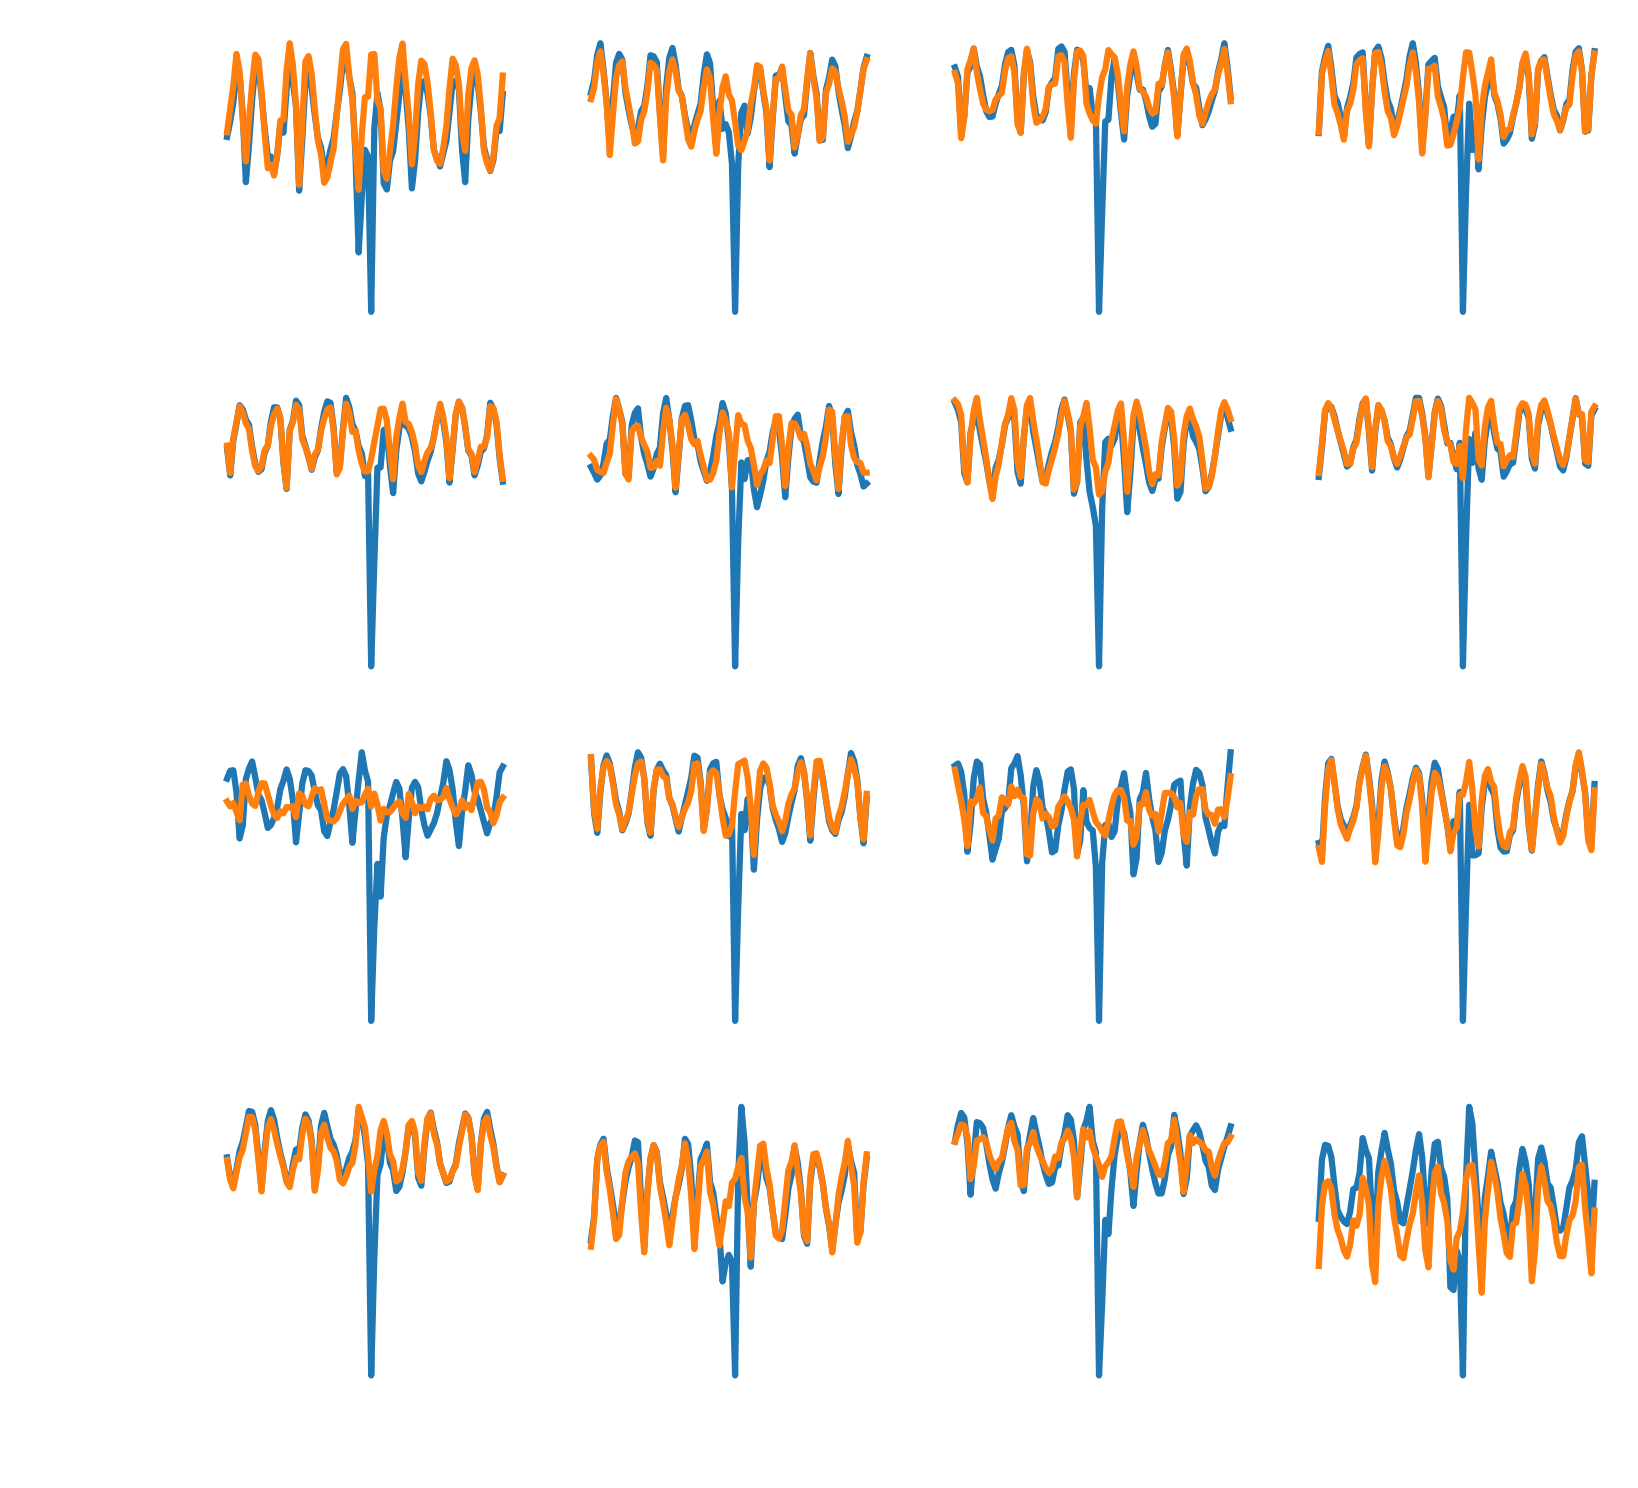

Reconstitute full iEEG with cleaned pulse periods...


In [3]:
base_sec = 50
sig = npz['signal'][:, [20]][tstamp >= base_sec]
sig_sham = npz['signal'][:, [20]][tstamp < base_sec]
sseq = npz['stim'][tstamp >= 50]*1e-6

signal_cleaned = zappy.elstim.artifact.ica_pulse_reconstruction(
                            signal=sig.copy(),
                            stim_seq=sseq.copy(),
                            inter_train_len=npz['Fs']*10.0,
                            padding=[40, 40],
                            #ic_summary_stat_func=,
                            ic_stat_pct=[2.5, 97.5],
                            signal_sham=sig_sham.copy(),
                            plot=True)

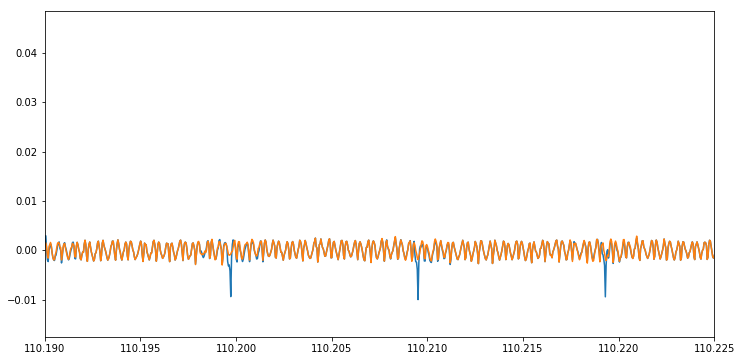

In [4]:
plt.figure(figsize=(12,6))
plt.plot(tstamp[tstamp >= base_sec], sig[:, 0])
plt.plot(tstamp[tstamp >= base_sec], signal_cleaned[:, 0])
plt.xlim([110.19, 110.225])
plt.show()

In [ ]:
from scipy import signal

f, Pxx_den = signal.welch(sig[:, 0], fs=npz['Fs'], nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
f, Pxx_den = signal.welch(signal_cleaned[:,0], fs=npz['Fs'], nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([0, 512])
plt.ylim([10**(-14), 10**(-7)])
plt.tight_layout()
plt.legend(['Original', 'Clean'])
plt.show()

f, Pxx_den = signal.welch(sig[:, 0], fs=npz['Fs'], nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
f, Pxx_den = signal.welch(signal_cleaned[:,0], fs=npz['Fs'], nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([0, 60])
plt.ylim([10**(-10), 10**(-7)])
plt.tight_layout()
plt.legend(['Original', 'Clean'])
plt.show()